# Libraries to be installed beforehand

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def load_data():
    data_df = pd.read_excel('/content/drive/My Drive/dataset/dataset.xlsx', engine='openpyxl')
    data_df.to_csv('output_reviews_top.csv')
load_data()

In [6]:
top_data_df = pd.read_csv('output_reviews_top.csv')
# print("Columns in the original dataset:\n")
# print(top_data_df.columns)

### Encoding 'POS' and 'NEG' reviews:

In [7]:
print("Number of rows per star rating:")
print(top_data_df['Sentiment'].value_counts())

Number of rows per star rating:
NEG    1000
POS     999
Name: Sentiment, dtype: int64


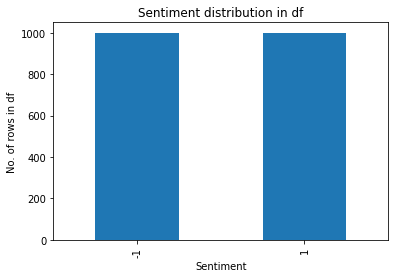

In [8]:
# Function to map stars to sentiment
def map_sentiment(sentiment):
    if sentiment == 'NEG':
        return -1
    else:
        return 1
# Mapping stars to sentiment into three categories
top_data_df['Sentiment_value'] = [map_sentiment(x) for x in top_data_df['Sentiment']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(top_data_df['Sentiment_value']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

### Selecting equal number of positive and negative reviews for training:

In [9]:
# Function to retrieve top few number of each category
def get_top_data(top_n):
    top_data_df_positive = top_data_df[top_data_df['Sentiment_value'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['Sentiment_value'] == -1].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative])
    return top_data_df_small

In [10]:
top_data_df_small = get_top_data(999)
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['Sentiment_value'].value_counts())

After segregating and taking equal number of rows for each sentiment:
 1    999
-1    999
Name: Sentiment_value, dtype: int64


In [11]:
top_data_df_small.head(10)

,Unnamed: 0,URL,Text,Sentiment,Sentiment_value
0,0,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS,1
1,1,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS,1
2,2,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS,1
3,3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS,1
4,4,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS,1
5,5,http://www.imdb.com/title/tt0347779/usercomments,A very good adaptation of the novel by amrita ...,POS,1
6,6,http://www.imdb.com/title/tt0095655/usercomments,"Ah, Moonwalker, I'm a huge Michael Jackson fan...",POS,1
7,7,http://www.imdb.com/title/tt0298131/usercomments,Although the beginning of the movie in New Yor...,POS,1
8,8,http://www.imdb.com/title/tt0088915/usercomments,"As many reviewers here have noted, the film ve...",POS,1
9,9,http://www.imdb.com/title/tt0828154/usercomments,"Bear in mind, any film (let alone documentary)...",POS,1


# Tokenization

In [12]:
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['Text']] 
print(top_data_df_small['tokenized_text'].head(10))

0    [girlfight, follows, project, dwelling, new, y...
1    [hollywood, north, is, an, euphemism, from, th...
2    [that, show, is, definitely, the, funniest, sh...
3    [minutes, of, pure, holiday, terror, okay, so,...
4    [series, of, random, seemingly, insignificant,...
5    [very, good, adaptation, of, the, novel, by, a...
6    [ah, moonwalker, huge, michael, jackson, fan, ...
7    [although, the, beginning, of, the, movie, in,...
8    [as, many, reviewers, here, have, noted, the, ...
9    [bear, in, mind, any, film, let, alone, docume...
Name: tokenized_text, dtype: object


## Stemming:

In [14]:
from gensim.parsing.porter import PorterStemmer

In [15]:
porter_stemmer = PorterStemmer()

In [16]:
# Get the stemmed_tokens
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
top_data_df_small['stemmed_tokens'].head(10)

0    [girlfight, follow, project, dwell, new, york,...
1    [hollywood, north, is, an, euphem, from, the, ...
2    [that, show, is, definit, the, funniest, show,...
3    [minut, of, pure, holidai, terror, okai, so, i...
4    [seri, of, random, seemingli, insignific, thef...
5    [veri, good, adapt, of, the, novel, by, amrita...
6    [ah, moonwalk, huge, michael, jackson, fan, gr...
7    [although, the, begin, of, the, movi, in, new,...
8    [as, mani, review, here, have, note, the, film...
9    [bear, in, mind, ani, film, let, alon, documen...
Name: stemmed_tokens, dtype: object

In [17]:
from gensim import corpora

In [18]:
# Build the dictionary
mydict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
print("Total unique words:", len(mydict.token2id))

Total unique words: 17708


In [21]:
print("\nSample data from dictionary:")
i = 0
for key in mydict.token2id.keys():
    print("Word: {} - ID: {} ".format(key, mydict.token2id[key]))
    if i == 3:
        break
    i += 1


Sample data from dictionary:
Word: abl - ID: 0 
Word: about - ID: 1 
Word: all - ID: 2 
Word: almost - ID: 3 


## Bag of Words embedding:

In [22]:
import gensim

In [25]:
vocab_len = len(mydict)
print("Example of how the BOW words")
arr = []
for line in top_data_df_small['stemmed_tokens']:
    print("Doc2Bow Line:")
    print(mydict.doc2bow(line), "\n")
    for word in line:
        arr.append(mydict.token2id[word])
    
    print("Actual line:")
    print(line, "\n")
    
    print("(Word, count) Tuples:")
    print([(mydict[id], count) for id, count in mydict.doc2bow(line) ], "\n")
    
    print("Sparse bow vector for the line")
    print(gensim.matutils.corpus2csc([mydict.doc2bow(line)],num_terms=vocab_len).toarray()[:,0], "\n")
    break

print("Sorted word id list")
print(sorted(arr))

Example of how the BOW words
Doc2Bow Line:
[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 5), (8, 1), (9, 1), (10, 5), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 2), (18, 1), (19, 2), (20, 2), (21, 1), (22, 2), (23, 2), (24, 2), (25, 2), (26, 3), (27, 1), (28, 2), (29, 1), (30, 1), (31, 2), (32, 4), (33, 2), (34, 1), (35, 2), (36, 3), (37, 2), (38, 2), (39, 1), (40, 5), (41, 2), (42, 2), (43, 1), (44, 1), (45, 1), (46, 2), (47, 2), (48, 3), (49, 2), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 5), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 2), (64, 2), (65, 2), (66, 1)] 

Actual line:
['girlfight', 'follow', 'project', 'dwell', 'new', 'york', 'high', 'school', 'girl', 'from', 'sens', 'of', 'futil', 'into', 'the', 'world', 'of', 'amateur', 'box', 'where', 'she', 'find', 'self', 'esteem', 'purpos', 'and', 'much', 'more', 'although', 'the', 'film', 'is', 'not', 'about', 'box', 'box', 'is', 'all', 'about', 'the', 'film', 'so', 'mu

## Splitting into train and test data:

In [28]:
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['URL', 'Text', 'stemmed_tokens']], 
                                                        top_data_df_small['Sentiment_value'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts(), "\n")
    print("Value counts for Test sentiments")
    print(Y_test.value_counts(), "\n")
    # print(type(X_train))
    # print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    # print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train sentiments
 1    712
-1    686
Name: Sentiment_value, dtype: int64 

Value counts for Test sentiments
-1    313
 1    287
Name: Sentiment_value, dtype: int64 



## Embedding on train data

In [29]:
import time
start_time = time.time()
vocab_len = len(mydict)
bow_filename = 'train_review_bow.csv'
with open(bow_filename, 'w+') as bow_file:
    for index, row in X_train.iterrows():
        features = gensim.matutils.corpus2csc([mydict.doc2bow(row['stemmed_tokens'])],num_terms=vocab_len).toarray()[:,0]
        if index == 0:
            # print("Header")
            header = ",".join(str(mydict[ele]) for ele in range(vocab_len))
            # print(header)
            bow_file.write(header)
            bow_file.write("\n")
        line1 = ",".join( [str(vector_element) for vector_element in features] )
        bow_file.write(line1)
        bow_file.write('\n')

print("Time taken to create bow for :" + str(time.time() - start_time))

Time taken to create bow for :10.886131048202515


##Function to generate classification report

In [31]:
# Iterating through test data to get the predictions of sentiment by the model
def generate_report(bow_clf):
  test_features = []
  start_time = time.time()
  for index, row in X_test.iterrows():
      # Converting the tokens into the format that the model requires
      features = gensim.matutils.corpus2csc([mydict.doc2bow(row['stemmed_tokens'])],num_terms=vocab_len).toarray()[:,0]
      test_features.append(features)
  test_predictions = bow_clf.predict(test_features)

  # Comparing the predictions to actual sentiments for the sentences
  print(classification_report(Y_test['Sentiment_value'],test_predictions))
  print("Time taken to predict the model " + str(time.time() - start_time))
  prec = precision_score(Y_test['Sentiment_value'],test_predictions)
  rec = recall_score(Y_test['Sentiment_value'],test_predictions)
  acc = accuracy_score(Y_test['Sentiment_value'],test_predictions)
  return prec, rec, acc

# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
bow_df = pd.read_csv('train_review_bow.csv')
bow_clf = DecisionTreeClassifier(random_state=0)
bow_clf.fit(bow_df, Y_train['Sentiment_value'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

## Find out the most important features from the bow classification model

In [ ]:
importances = list(bow_clf.feature_importances_)
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(bow_df.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
top_i = 0
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))
    if top_i == 20:
        break
    top_i += 1

Variable: bad                  Importance: 0.1669461871
Variable: wast                 Importance: 0.1254934397
Variable: excel                Importance: 0.0692289262
Variable: bore                 Importance: 0.054036118
Variable: poor                 Importance: 0.0532591927
Variable: ridicul              Importance: 0.0360510426
Variable: film                 Importance: 0.023788887
Variable: charact              Importance: 0.0231885279
Variable: worst                Importance: 0.0224430566
Variable: poorli               Importance: 0.0201562152
Variable: neither              Importance: 0.018965248
Variable: person               Importance: 0.018254452
Variable: black                Importance: 0.0173945218
Variable: idiot                Importance: 0.0165003857
Variable: pathet               Importance: 0.0164166877
Variable: terribl              Importance: 0.01604762
Variable: perfect              Importance: 0.0147043636
Variable: badli                Importance: 0.014507065

In [33]:
dt_metrics = [None, None, None]
dt_metrics[0], dt_metrics[1], dt_metrics[2] = generate_report(bow_clf)

              precision    recall  f1-score   support

          -1       0.89      0.90      0.90       313
           1       0.89      0.87      0.88       287

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

Time taken to predict the model 0.4477417469024658


# Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
bow_df = pd.read_csv('train_review_bow.csv')
bow_clf = LogisticRegression(max_iter=300)
bow_clf.fit(bow_df, Y_train['Sentiment_value'])
bow_clf.fit(bow_df,Y_train['Sentiment_value'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Find out the most important features from the bow classification model

In [36]:
lr_metrics = [None, None, None]
lr_metrics[0], lr_metrics[1], lr_metrics[2] = generate_report(bow_clf)

              precision    recall  f1-score   support

          -1       0.87      0.88      0.87       313
           1       0.87      0.85      0.86       287

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600

Time taken to predict the model 0.5294733047485352


# Support Vector Machine (SVM)

In [37]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report

In [38]:
bow_df = pd.read_csv('train_review_bow.csv')
bow_clf = svm.SVC(kernel='linear')
bow_clf.fit(bow_df, Y_train['Sentiment_value'])
bow_clf.fit(bow_df,Y_train['Sentiment_value'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [39]:
svm_metrics = [None, None, None]
svm_metrics[0], svm_metrics[1], svm_metrics[2] = generate_report(bow_clf)

              precision    recall  f1-score   support

          -1       0.85      0.88      0.86       313
           1       0.86      0.83      0.85       287

    accuracy                           0.85       600
   macro avg       0.86      0.85      0.85       600
weighted avg       0.86      0.85      0.85       600

Time taken to predict the model 14.847397565841675


# Multinomial Naive Bayes

In [40]:
from sklearn.naive_bayes import MultinomialNB

In [41]:
bow_df = pd.read_csv('train_review_bow.csv')
bow_clf = MultinomialNB()
bow_clf.fit(bow_df, Y_train['Sentiment_value'])
bow_clf.fit(bow_df,Y_train['Sentiment_value'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
mnb_metrics = [None, None, None]
mnb_metrics[0], mnb_metrics[1], mnb_metrics[2] = generate_report(bow_clf)

              precision    recall  f1-score   support

          -1       0.84      0.89      0.86       313
           1       0.87      0.82      0.84       287

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

Time taken to predict the model 0.5155248641967773


# Bernoulli Naive Bayes

In [43]:
from sklearn.naive_bayes import BernoulliNB

In [44]:
bow_df = pd.read_csv('train_review_bow.csv')
bow_clf = BernoulliNB()
bow_clf.fit(bow_df, Y_train['Sentiment_value'])
bow_clf.fit(bow_df,Y_train['Sentiment_value'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [45]:
bnb_metrics = [None, None, None]
bnb_metrics[0], bnb_metrics[1], bnb_metrics[2] = generate_report(bow_clf)

              precision    recall  f1-score   support

          -1       0.86      0.83      0.85       313
           1       0.82      0.86      0.84       287

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600

Time taken to predict the model 0.5755095481872559


#Results comparision plots and tables

In [46]:
!pip3 install tabulate
from tabulate import tabulate
table = [['Model Name', 'Accuracy', 'Precision', 'Recall'],
         ['Bernoulli Naïve Bayes', bnb_metrics[0], bnb_metrics[1], bnb_metrics[2]],
         ['Support Vector Machine', svm_metrics[0], svm_metrics[1], svm_metrics[2]],
         ['Maximum Entropy', lr_metrics[0], lr_metrics[1], lr_metrics[2]],
         ['Decision Tree', dt_metrics[0], dt_metrics[1], dt_metrics[2]]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════════╤════════════╤═════════════╤══════════╕
│ Model Name             │   Accuracy │   Precision │   Recall │
╞════════════════════════╪════════════╪═════════════╪══════════╡
│ Bernoulli Naïve Bayes  │   0.82     │    0.857143 │ 0.841667 │
├────────────────────────┼────────────┼─────────────┼──────────┤
│ Support Vector Machine │   0.859712 │    0.832753 │ 0.855    │
├────────────────────────┼────────────┼─────────────┼──────────┤
│ Maximum Entropy        │   0.868794 │    0.853659 │ 0.868333 │
├────────────────────────┼────────────┼─────────────┼──────────┤
│ Decision Tree          │   0.893238 │    0.874564 │ 0.89     │
╘════════════════════════╧════════════╧═════════════╧══════════╛


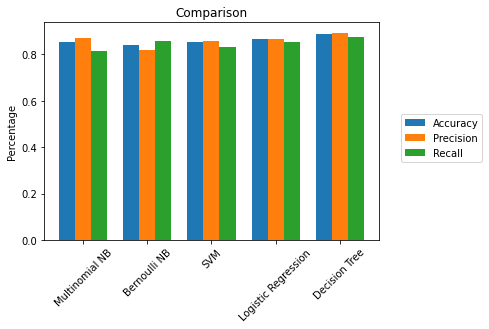

In [ ]:
N = 5
ind = np.arange(N) 
width = 0.25
  
acc = [mnb_metrics[2], bnb_metrics[2], svm_metrics[2], lr_metrics[2], dt_metrics[2]]
bar1 = plt.bar(ind, acc, width)
  
prec = [mnb_metrics[0], bnb_metrics[0], svm_metrics[0], lr_metrics[0], dt_metrics[0]]
bar2 = plt.bar(ind+width, prec, width)
  
recall = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1]]
bar3 = plt.bar(ind+width*2, recall, width)
  
# plt.xlabel("Dates")
plt.ylabel("Percentage")
plt.title("Comparison")
  
plt.xticks(ind+width,['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree'])
plt.xticks(rotation = 45)
plt.legend( (bar1, bar2, bar3), ('Accuracy', 'Precision', 'Recall'), bbox_to_anchor = (1.05, 0.6))
plt.show()

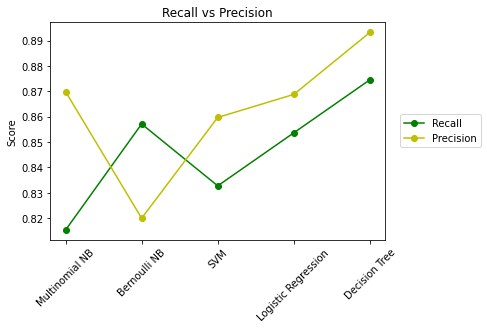

In [ ]:
models = ['Multinomial NB','Bernoulli NB','SVM','Logistic Regression', 'Decision Tree']
recall = [mnb_metrics[1], bnb_metrics[1], svm_metrics[1], lr_metrics[1], dt_metrics[1]]
precision = [mnb_metrics[0], bnb_metrics[0], svm_metrics[0], lr_metrics[0], dt_metrics[0]]
line_chart1 = plt.plot(models, recall, 'o-g')
line_chart2 = plt.plot(models, precision, 'o-y')
plt.title('Recall vs Precision')
plt.ylabel('Score')
plt.xticks(rotation = 45)
plt.legend(['Recall', 'Precision'], bbox_to_anchor = (1.3, 0.6))
plt.show()